In [11]:
import qiskit
from qiskit import QuantumCircuit
qiskit.__version__

'0.21.0'

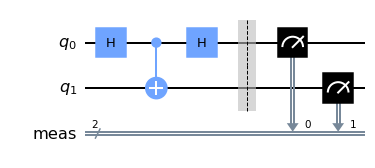

In [13]:
bomb_tester = QuantumCircuit(2)
# Hadamard gate
bomb_tester.h(0)
# C-NOT gate
bomb_tester.cx(0, 1)
# Hadamard gate
bomb_tester.h(0)
# Measure
bomb_tester.measure_all()
bomb_tester.draw(output='mpl')

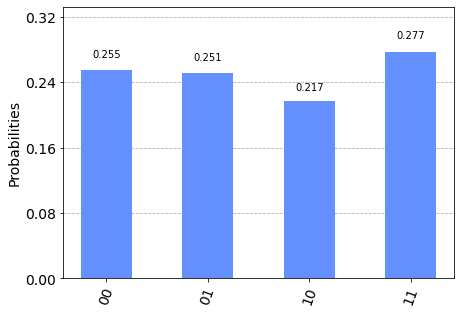

In [23]:
from qiskit.providers.aer import QasmSimulator
simulator = QasmSimulator()

job = simulator.run(bomb_tester, shots = 1000)
result = job.result()
counts = result.get_counts(bomb_tester)

from qiskit.visualization import plot_histogram
plot_histogram(counts)

In [24]:
# photon qubit is the least significant bit
# 1 means the bomb/C-NOT gate is there
# the rest of the qubits is the bomb qubit
# 0 means the bomb didn't explode and 1 otherwise
# 01 is what we are looking for, it shows that the bomb-tester is working and the bomb did not explode

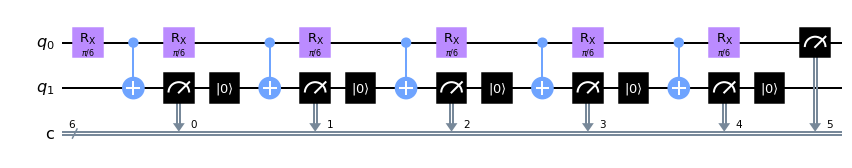

In [26]:
from qiskit.circuit import QuantumRegister, ClassicalRegister
import numpy as np
from qiskit.circuit.library import RXGate

cycles = 6 # Number of times the photon passes through beam splitter, higher number = higher probability to not detonate the bomb
theta = np.pi/cycles # The correct reflectivity of beamsplitter is chosen for the quantum Zeno effect to work

#Create quantum circuit
qr = QuantumRegister(2, 'q')
cr = ClassicalRegister(cycles, 'c')
zeno_tester = QuantumCircuit(qr, cr)

# Create a chain of our variable beamsplitters and C-NOT bombs
for cycle in range(cycles-1):
    zeno_tester.append(RXGate(theta), [qr[0]])
    zeno_tester.cx(0, 1)
    zeno_tester.measure(qr[1], cr[cycle])
    zeno_tester.reset(qr[1])
    
# Add a final beamsplitter
zeno_tester.append(RXGate(theta), [qr[0]])

# Measure our photon to predict whether there is a bomb, and measure qubit to see if it exploded
zeno_tester.measure(qr[0], cr[cycles-1])
zeno_tester.draw(output='mpl')

In [17]:
# Each of the beamsplitters is a X rotation gate
# Using beamsplitters and C-NOT gate to simulate the photon passing through the beamsplitters lots of times 
# And measure each time after the photon passes through the beamsplitter to check if the bomb has exploded

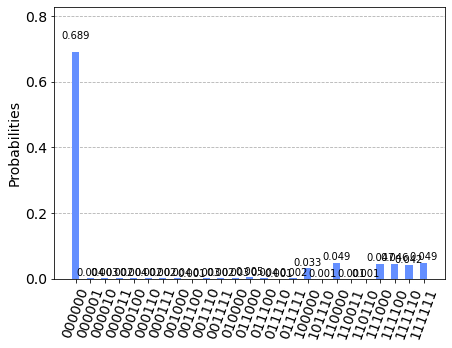

In [18]:
zeno_job = simulator.run(zeno_tester, shots = 1000)
zeno_result = zeno_job.result()
zeno_counts = zeno_result.get_counts(zeno_tester)

plot_histogram(zeno_counts)

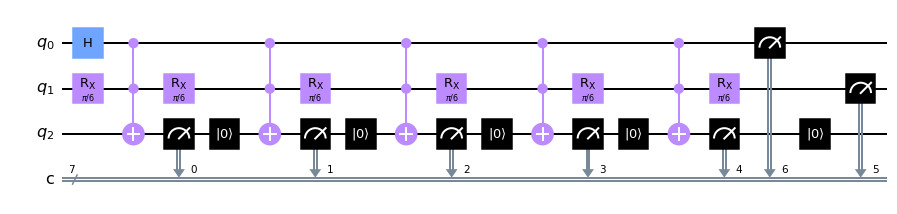

In [29]:
from qiskit.circuit.library import CCXGate

def quantum_sweeper(cycles) -> QuantumCircuit: 
    qr = QuantumRegister(3, 'q')
    cr = ClassicalRegister(cycles+1, 'c')
    qc = QuantumCircuit(qr, cr)
    qc.h(qr[0])
    for cycle in range(cycles - 1):
        qc.append(RXGate(theta), [qr[1]])
        qc.ccx(qr[0], qr[1], qr[2])
        qc.measure(qr[2], cr[cycle])
        if cycle < cycles -1:
            qc.reset(qr[2])
            
    qc.append(RXGate(theta), [qr[1]])
    qc.measure(qr[1], cr[cycles - 1])
    qc.measure(qr[0], cr[cycles])
    return qc

cycles = 6
theta = np.pi/cycles

zeno_circuit = quantum_sweeper(cycles)
zeno_circuit.draw(output='mpl')